FGKcupid with period as the dependent variable.

In [15]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import george
from george.kernels import ExpSquaredKernel, WhiteKernel
import pandas as pd
import emcee
from MCMC_plots import make_plot
import time
import h5py
import os
from teff_bv import teff2bv
import corner

RESULTS_DIR = "results"
DATA_DIR = "data"

In [16]:
# plot model
def log_period_model(par, log_a, bv):
    return np.log10(par[0]) + par[1] * log_a + par[2] * np.log10(bv - par[3])

def period_model(par, a, bv):
    log_a = np.log10(a*1000)
    return 10**(np.log10(par[0]) + par[1] * log_a + par[2] * np.log10(bv - par[3]))

def load_original_data():
    # load data
    bv, bv_err, p, p_err, a, a_err, logg, logg_err, f = \
        np.genfromtxt("data/clusters.txt").T

    # load 16Cyg A
    bv16, bv_err16, p16, perr16, a16, aerr16, _, _, _, _ = \
        np.genfromtxt("data/16CygA.txt").T

    # load NGC6819
    bv19s, p19s = np.genfromtxt("data/NGC6819.txt", skip_header=1).T
    a19s = np.ones_like(p19s)*2.5
    
    # add M67 (rebecca + barnes)
    epic, bv67, v, p67, perr67 = np.genfromtxt("data/barnes_M67.txt", skip_header=1).T
    #epic, p67, bv67, bv_067, _ = np.genfromtxt("data/acf_ls_results.txt", skip_header=1,
    #                                     delimiter=",").T
    a67 = np.ones_like(p67) * 4
    
    # load astero
    data = pd.read_csv("data/garcia_irfm.csv")
    bv1 = teff2bv(data.teff, data.logg, data.feh)
    m1 = data.logg > 4
    
    bv = np.concatenate((bv, bv16, bv19s, bv67, bv1[m1]))
    bv_err = np.concatenate((bv_err, bv_err16, np.ones_like(bv19s)*.01, np.ones_like(bv67)*.01, 
                            np.ones_like(bv1[m1])*.01))
    p = np.concatenate((p, p16, p19s, p67, data.period[m1]))
    p_err = np.concatenate((p_err, perr16, p19s*.1, p67*.1, data.period_err[m1]))
    a = np.concatenate((a, a16, a19s, a67, data.age[m1]))
    a_err = np.concatenate((a_err, aerr16, a19s*.1, a67*.1, .5*(data.age_errp[m1]+data.age_errm[m1])))
    
    return a, a_err, p, p_err, bv, bv_err

a, a_err, p, p_err, bv, bv_err = load_original_data()

/Users/ruthangus/projects/fgkcupid/dev/teff_bv.py:16: RuntimeWarning: invalid value encountered in log10
  + d1*feh*np.log10(teff) + g1*logg + e1*logg*np.log10(teff)


In [17]:
# select based on colour
m = (.6 < bv) * (bv < .7) * (p > 5) * (a/p < 1)
pars = [.407, .566, .325, .495]  # MH
xp = np.linspace(0, 20, 100)
A, lbv, lp, sigma = 10, 2000, 10, 1.
x, y, xerr, yerr = a[m], p[m], a_err[m], p_err[m]

/Users/ruthangus/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in greater
  from ipykernel import kernelapp as app
/Users/ruthangus/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in less
  from ipykernel import kernelapp as app


Compute the model

In [18]:
k = A**2 * ExpSquaredKernel(lp**2)
gp = george.GP(k)
gp.compute(x, (yerr**2+sigma**2)**.5)
    
mod1 = period_model(pars, x, .65)
    
mus, covs = gp.predict(y - mod1, xp)
vs = np.diag(covs)**.5
    
mod2 = period_model(pars, xp, .65)

/Users/ruthangus/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:6: RuntimeWarning: divide by zero encountered in log10


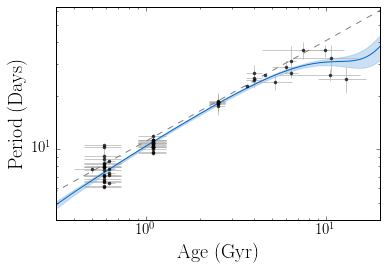

In [19]:
plt.plot(xp, mus+mod2, color='#0066CC')
plt.fill_between(xp, mus-vs+mod2, mus+vs+mod2, alpha=.2, color='#0066CC')

plt.plot(xp, mod2, '.5', ls="--")
plt.errorbar(a[m], p[m], xerr=a_err[m], yerr=p_err[m], fmt="k.", capsize=0, ecolor=".7", alpha=.7)

plt.xlim(10**-.5, 10**1.3)
plt.ylim(10**.6, 10**1.8)
plt.xlabel("$\mathrm{Age~(Gyr)}$")
plt.ylabel("$\mathrm{Period~(Days)}$")
plt.loglog()
plt.subplots_adjust(left=.15, bottom=.16)
plt.savefig("fgkcupid_demo.pdf")

Flip axes

In [20]:
# select based on colour
m = (.6 < bv) * (bv < .7) * (p > 5) * (a/p < 1)
xp = np.linspace(0, 50, 100)
A, lp, sigma = 10, 5, 1.
y, x, z, yerr, xerr, zerr = a[m], p[m], bv[m], a_err[m], p_err[m], np.ones_like(bv)*.01

/Users/ruthangus/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in greater
  from ipykernel import kernelapp as app
/Users/ruthangus/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in less
  from ipykernel import kernelapp as app


In [21]:
def age_model(p, bv):
    a, n, b, c = .407, .566, .325, .495  # MH
    return (p / (a * (bv - c)**b))**(1./n) / 1000

In [22]:
k = A**2 * ExpSquaredKernel(lp**2)
gp = george.GP(k)
gp.compute(x, (yerr**2+sigma**2)**.5)
mod1 = age_model(x, .65)
mus, covs = gp.predict(y - mod1, xp)
vs = np.diag(covs)**.5 
mod2 = age_model(xp, .65)

[]

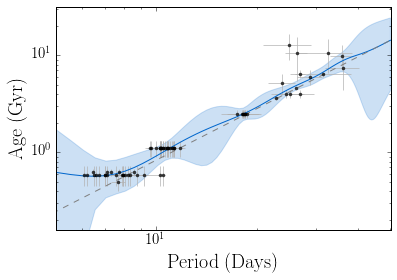

In [23]:
plt.plot(xp, mus + mod2, color='#0066CC')
plt.fill_between(xp, mus - vs + mod2, mus + vs + mod2, alpha=.2, color='#0066CC')
plt.plot(xp, mod2, '.5', ls="--")
plt.errorbar(x, y, xerr=xerr, yerr=yerr, fmt="k.", capsize=0, ecolor=".7", alpha=.7)
plt.ylabel("$\mathrm{Age~(Gyr)}$")
plt.xlabel("$\mathrm{Period~(Days)}$")
plt.xlim(10**.7, 10**1.7)
plt.ylim(10**-.8, 10**1.5)
plt.loglog()

In [24]:
A, lbv, lp, sigma = 10, 2000, 5, 1.
theta_init = np.log(np.array([A, lbv, lp, sigma]))  # initial guess

In [25]:
def lnprior(theta):  # very broad uniform log prior
    if -20 < theta[0] < 20 and -20 < theta[1] < 20 and -20 < theta[2] < 20 and -20 < theta[3] < 20:
        return 0.
    return -np.inf

In [26]:
def lnlike(theta, x, y, z, yerr):
    theta = np.exp(theta)
    D = np.vstack((x, z)).T
    k = theta[0]**2 * ExpSquaredKernel([theta[1]**2, theta[2]**2], ndim=2)
    gp = george.GP(k)
    try:
        gp.compute(D, (yerr**2 + theta[3]**2)**.5)
    except (ValueError, np.linalg.LinAlgError):
        return 10e25
    r = y - age_model(z, x)
    m = np.isfinite(r)
    if len(r) > len(r[m]):
        return -np.inf
    return gp.lnlikelihood(r, quiet=True)

In [27]:
def lnprob(theta, x, y, z, yerr):
    return lnlike(theta, x, y, z, yerr) + lnprior(theta)

In [28]:
burnin, nwalkers, ndim = 1000, 24, len(theta_init)
runs = np.zeros(5) + 1000
p0 = [theta_init+1e-4*np.random.rand(ndim) for i in range(nwalkers)]
args = (x, y, z, yerr)

Time the LHF call

In [29]:
start = time.time()
print("lnprob = ", lnprob(theta_init, x, y, z, yerr))
end = time.time()
tm = end - start
print("1 lhf call takes ", tm, "seconds")
print("burn in will take", tm * nwalkers * burnin, "s")
print("each run will take", tm * nwalkers * sum(runs)/60, "mins")
print("total = ", (tm * nwalkers * sum(runs) + tm * nwalkers * burnin)/60, "mins")

lnprob =  -144.54477129
1 lhf call takes  0.0022339820861816406 seconds
burn in will take 53.615570068359375 s
each run will take 4.46796417236 mins
total =  5.36155700684 mins


Run the MCMC.

burning in..., 1000 steps


/Users/ruthangus/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:6: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


production run, 1000 steps
time taken =  0.32542118231455486 minutes

 5.84183389291e-06 period (days) 

[  2.12872537   3.46740714   2.06477179 -12.05046579]
Plotting traces


/Users/ruthangus/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:16: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/ruthangus/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:23: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


Making triangle plot
plotting prediction
production run, 1000 steps
time taken =  0.30948865016301474 minutes

 6.19616285148e-06 period (days) 

[  2.08660134   3.42995728   2.03050227 -11.99158035]
Plotting traces
Making triangle plot
plotting prediction
production run, 1000 steps
time taken =  0.3247379501660665 minutes

 8.20078255152e-06 period (days) 

[  2.0654745    3.41880341   2.08939288 -11.71128098]
Plotting traces
Making triangle plot
plotting prediction
production run, 1000 steps
time taken =  0.3435450832049052 minutes

 8.02527553825e-06 period (days) 

[  2.09416907   3.42682185   2.15346974 -11.73291455]
Plotting traces
Making triangle plot
plotting prediction
production run, 1000 steps
time taken =  0.34917476574579875 minutes

 9.7464831447e-06 period (days) 

[  2.09329688   3.42639701   2.1655674  -11.53860404]
Plotting traces
Making triangle plot
plotting prediction


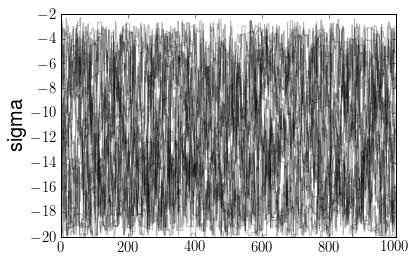

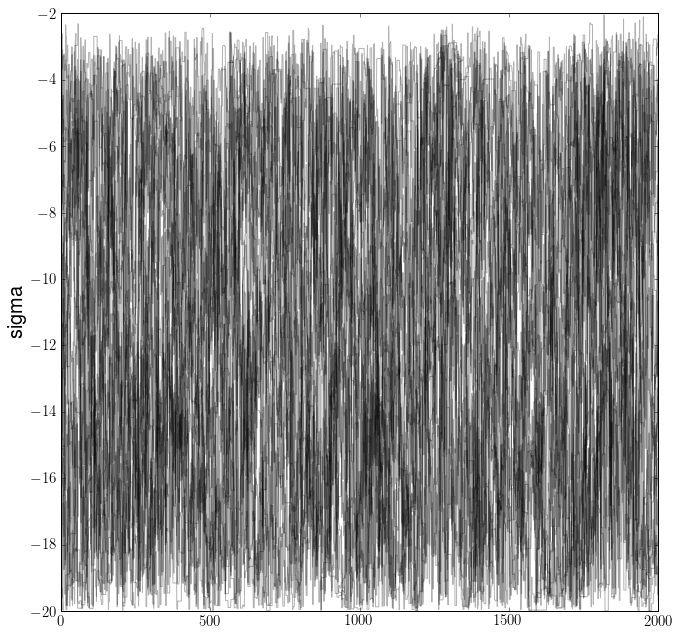

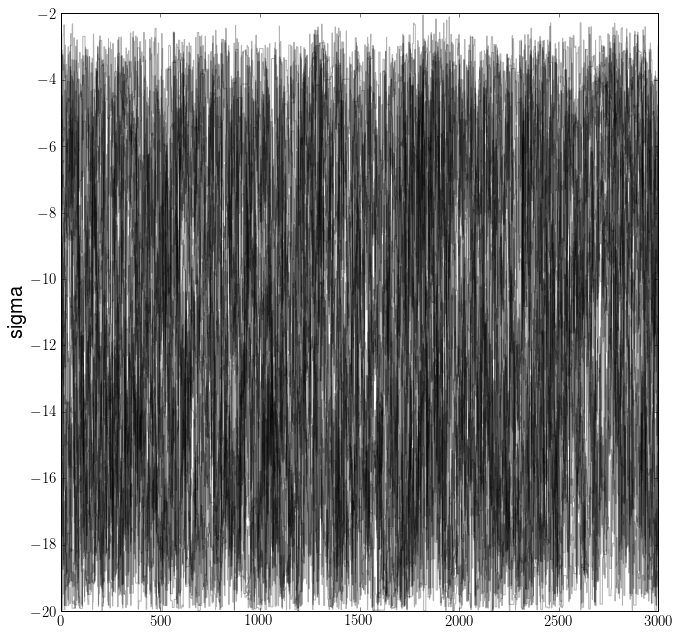

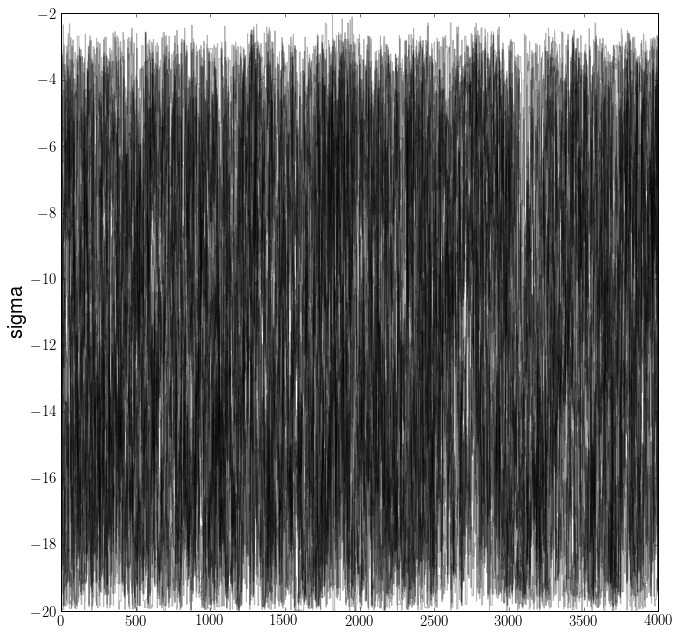

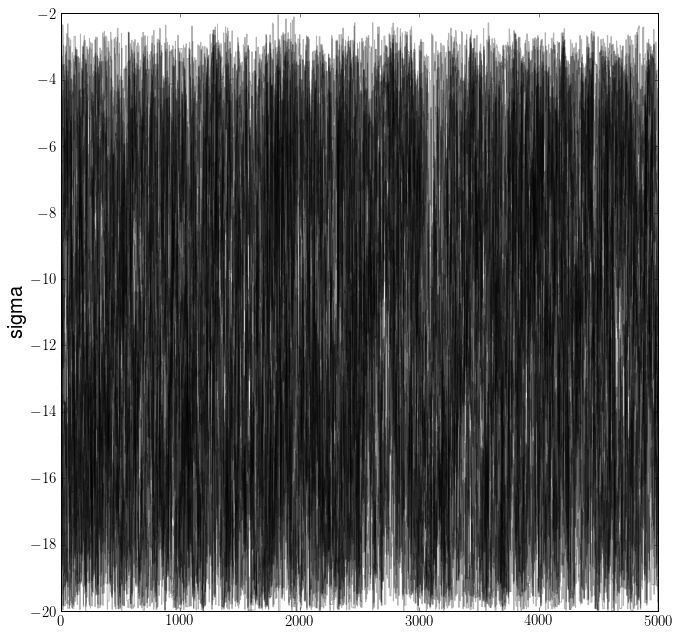

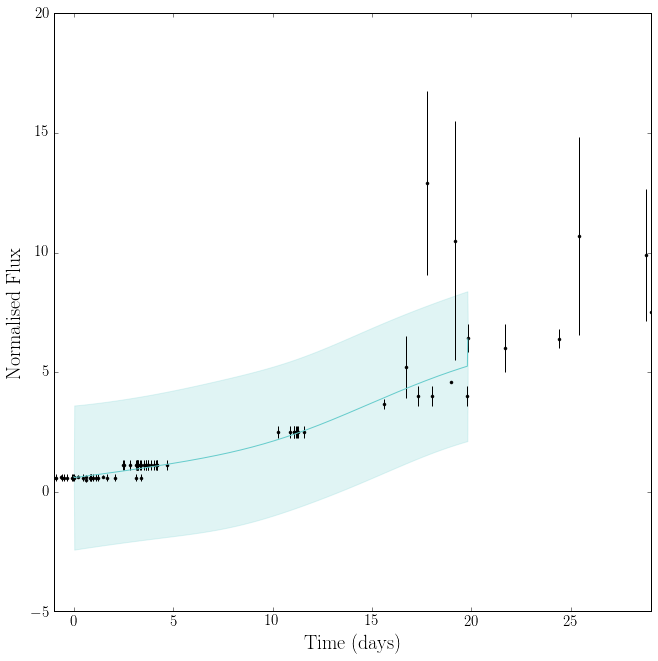

In [69]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=args)
print("burning in..., {0} steps".format(int(burnin)))
p0, _, state = sampler.run_mcmc(p0, burnin)
fig_labels = ["A", "lbv", "lp", "sigma"]

sample_array = np.zeros((nwalkers, sum(runs), ndim))
for i, run in enumerate(runs):
    sampler.reset()
    print("production run, {0} steps".format(int(run)))
    start = time.time()
    p0, _, state = sampler.run_mcmc(p0, run)
    end = time.time()
    print("time taken = ", (end - start)/60, "minutes")
    
    # save samples
    sample_array[:, sum(runs[:i]):sum(runs[:(i+1)]), :] = np.array(sampler.chain)
    f = h5py.File(os.path.join(RESULTS_DIR, "3Dsamples.h5"), "w")
    data = f.create_dataset("samples", np.shape(sample_array))
    data[:, :] = sample_array
    f.close()
    
    # make plots at increments
    mcmc_result = make_plot(sample_array[:, :sum(runs[:(i+1)]), :], x, y, yerr, fig_labels, "3D", 
                            RESULTS_DIR, traces=True, tri=True, prediction=True)

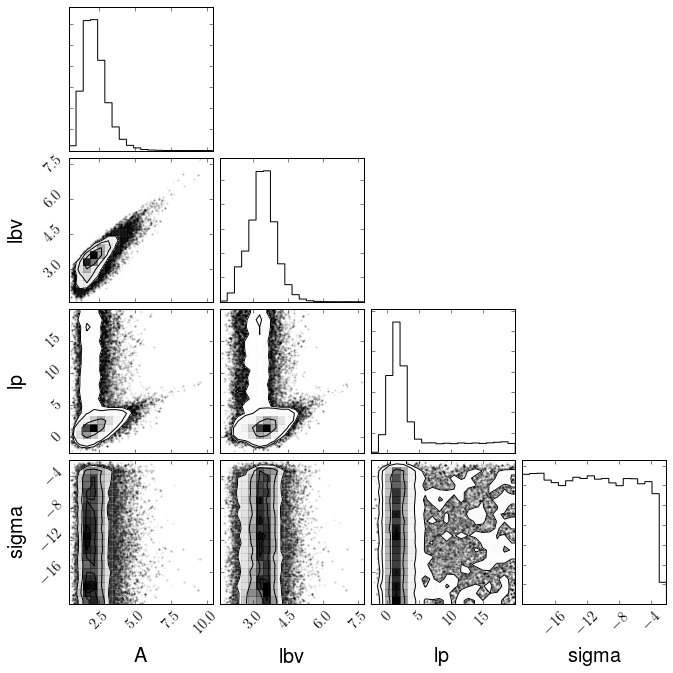

In [30]:
# load the results
with h5py.File(os.path.join(RESULTS_DIR, "3Dsamples.h5"), "r") as f:
    samples = f["samples"][...]
nwalkers, nsteps, ndims = np.shape(samples)
flat = np.reshape(samples, (nwalkers * nsteps, ndims))
mcmc_result = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]), 
                  zip(*np.percentile(flat, [16, 50, 84], axis=0)))
theta = np.exp(np.array([i[0] for i in mcmc_result]))
A, lbv, lp, sigma = theta
fig = corner.corner(flat, labels=["A", "lbv", "lp", "sigma"])

(0.15848931924611134, 19.952623149688797)

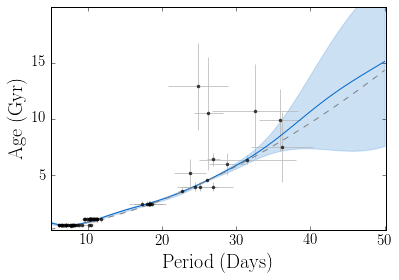

In [31]:
k = A**2 * ExpSquaredKernel(lp**2)
gp = george.GP(k)
#gp.compute(x, (yerr**2+sigma**2)**.5)
gp.compute(x, (yerr**2)**.5)
mod1 = age_model(x, .65)
mus, covs = gp.predict(y - mod1, xp)
vs = np.diag(covs)**.5 
mod2 = age_model(xp, .65)

plt.plot(xp, mus + mod2, color='#0066CC')
plt.fill_between(xp, mus - vs + mod2, mus + vs + mod2, alpha=.2, color='#0066CC')
plt.plot(xp, mod2, '.5', ls="--")
plt.errorbar(x, y, xerr=xerr, yerr=yerr, fmt="k.", capsize=0, ecolor=".7", alpha=.7)
plt.ylabel("$\mathrm{Age~(Gyr)}$")
plt.xlabel("$\mathrm{Period~(Days)}$")
plt.xlim(10**.7, 10**1.7)
plt.ylim(10**-.8, 10**1.3)

In [36]:
def fgkcupid(mybv, myperiod):
    """
    Given a rotation period and a colour, calculate the age.
    """
    
    # load the data for conditioning...
    a, a_err, p, p_err, bv, bv_err = load_original_data()
    m = (.6 < bv) * (bv < .7) * (p > 5) * (a/p < 1)
    xp = np.linspace(0, 50, 100)
    A, lp, sigma = 10, 5, 1.
    y, x, z, yerr, xerr, zerr = a[m], p[m], bv[m], a_err[m], p_err[m], np.ones_like(bv)*.01
    
    # load the results
    with h5py.File(os.path.join(RESULTS_DIR, "3Dsamples.h5"), "r") as f:
            samples = f["samples"][...]
    nwalkers, nsteps, ndims = np.shape(samples)
    flat = np.reshape(samples, (nwalkers * nsteps, ndims))
    mcmc_result = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]), 
                      zip(*np.percentile(flat, [16, 50, 84], axis=0)))
    theta = np.exp(np.array([i[0] for i in mcmc_result]))

    A, lbv, lp, sigma = theta
        
    D = np.vstack((z, x)).T
    k = A**2 * ExpSquaredKernel([lbv**2, lp**2], ndim=2)
    gp = george.GP(k)
    gp.compute(D, (yerr**2 + sigma**2)**.5)
    xs = np.zeros((1, 2))
    xs[0, 0] = mybv
    xs[0, 1] = myperiod
    mu, cov = gp.predict(y - age_model(myperiod, mybv), xs)  # do the GP prediction
    v = np.diag(cov)**.5
    mu += age_model(myperiod, mybv)
    
    print("Age = {0} +/- {1} Gyr".format(mu[0], v[0]))
    return mu, v

In [37]:
print(fgkcupid(.65, 26))

Age = 4.538993207374421 +/- 0.005821619847075108 Gyr
(array([ 4.53899321]), array([ 0.00582162]))


/Users/ruthangus/projects/fgkcupid/dev/teff_bv.py:16: RuntimeWarning: invalid value encountered in log10
  + d1*feh*np.log10(teff) + g1*logg + e1*logg*np.log10(teff)
/Users/ruthangus/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:8: RuntimeWarning: invalid value encountered in greater
/Users/ruthangus/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:8: RuntimeWarning: invalid value encountered in less
